<a href="https://colab.research.google.com/github/rohamkaveie/nma2023-project-hcptask/blob/master/load_hcp_task_with_behaviour.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load HCP parcellated task data
## (version with Behavioural Data)

The HCP dataset comprises task-based fMRI from a large sample of human subjects. The NMA-curated dataset includes time series data that has been preprocessed and spatially-downsampled by aggregating within 360 regions of interest.

In order to use this dataset, please electronically sign the HCP data use terms at [ConnectomeDB](https://db.humanconnectome.org). Instructions for this are on pp. 24-25 of the [HCP Reference Manual](https://www.humanconnectome.org/storage/app/media/documentation/s1200/HCP_S1200_Release_Reference_Manual.pdf).

In this notebook, NMA provides code for downloading the data and doing some basic visualisation and processing.

In [1]:
# @title Install dependencies
!pip install nilearn --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 30.5 MB/s eta 0:00:00


In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [3]:
#@title Figure settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [4]:
# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 100

# The data have already been aggregated into ROIs from the Glasser parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in seconds

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated twice in each subject
RUNS   = ['LR','RL']
N_RUNS = 2

# There are 7 tasks. Each has a number of 'conditions'
# TIP: look inside the data folders for more fine-graned conditions

EXPERIMENTS = {
    'MOTOR'      : {'cond':['lf','rf','lh','rh','t','cue']},
    'WM'         : {'cond':['0bk_body','0bk_faces','0bk_places','0bk_tools','2bk_body','2bk_faces','2bk_places','2bk_tools']},
    'EMOTION'    : {'cond':['fear','neut']},
    'GAMBLING'   : {'cond':['loss','win']},
    'LANGUAGE'   : {'cond':['math','story']},
    'RELATIONAL' : {'cond':['match','relation']},
    'SOCIAL'     : {'cond':['ment','rnd']}
}

> For a detailed description of the tasks have a look pages 45-54 of the [HCP reference manual](https://www.humanconnectome.org/storage/app/media/documentation/s1200/HCP_S1200_Release_Reference_Manual.pdf).

# Downloading data

The task data are shared in different files, but they will unpack into the same directory structure.


In [5]:
# @title Download data file
import os, requests

fname = "hcp_task.tgz"
url = "https://osf.io/2y3fw/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [6]:
# The download cells will store the data in nested directories starting here:
HCP_DIR = "./hcp_task"

# importing the "tarfile" module
import tarfile

# open file
with tarfile.open(fname) as tfile:
  # extracting file
  tfile.extractall('.')

subjects = np.loadtxt(os.path.join(HCP_DIR, 'subjects_list.txt'), dtype='str')

## Understanding the folder organisation

The data folder has the following organisation:

- hcp
  - regions.npy (information on the brain parcellation)
  - subjects_list.txt (list of subject IDs)
  - subjects (main data folder)
    - [subjectID] (subject-specific subfolder)
      - EXPERIMENT (one folder per experiment)
        - RUN (one folder per run)
          - data.npy (the parcellated time series data)
          - EVs (EVs folder)
            - [ev1.txt] (one file per condition)
            - [ev2.txt]
            - Stats.txt (behavioural data [where available] - averaged per run)
            - Sync.txt (ignore this file)



## Loading region information

Downloading this dataset will create the `regions.npy` file, which contains the region name and network assignment for each parcel.

Detailed information about the name used for each region is provided [in the Supplement](https://static-content.springer.com/esm/art%3A10.1038%2Fnature18933/MediaObjects/41586_2016_BFnature18933_MOESM330_ESM.pdf) to [Glasser et al. 2016](https://www.nature.com/articles/nature18933).

Information about the network parcellation is provided in [Ji et al, 2019](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6289683/).



In [7]:
regions = np.load(f"{HCP_DIR}/regions.npy").T
region_info = dict(
    name=regions[0].tolist(),
    network=regions[1],
    hemi=['Right']*int(N_PARCELS/2) + ['Left']*int(N_PARCELS/2),
)

# Help functions

We provide two helper functions: one for loading the time series from a single suject and a single run, and one for loading an EV file for each task.

An EV file (EV:Explanatory Variable) describes the task experiment in terms of stimulus onset, duration, and amplitude. These can be used to model the task time series data.

In [8]:
def load_single_timeseries(subject, experiment, run, remove_mean=True):
  """Load timeseries data for a single subject and single run.

  Args:
    subject (str):      subject ID to load
    experiment (str):   Name of experiment
    run (int):          (0 or 1)
    remove_mean (bool): If True, subtract the parcel-wise mean (typically the mean BOLD signal is not of interest)

  Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

  """
  bold_run  = RUNS[run]
  bold_path = f"{HCP_DIR}/subjects/{subject}/{experiment}/tfMRI_{experiment}_{bold_run}"
  bold_file = "data.npy"
  ts = np.load(f"{bold_path}/{bold_file}")
  if remove_mean:
    ts -= ts.mean(axis=1, keepdims=True)
  return ts


def load_evs(subject, experiment, run):
  """Load EVs (explanatory variables) data for one task experiment.

  Args:
    subject (str): subject ID to load
    experiment (str) : Name of experiment
    run (int): 0 or 1

  Returns
    evs (list of lists): A list of frames associated with each condition

  """
  frames_list = []
  task_key = f'tfMRI_{experiment}_{RUNS[run]}'
  for cond in EXPERIMENTS[experiment]['cond']:
    ev_file  = f"{HCP_DIR}/subjects/{subject}/{experiment}/{task_key}/EVs/{cond}.txt"
    ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
    ev       = dict(zip(["onset", "duration", "amplitude"], ev_array))
    # Determine when trial starts, rounded down
    start = np.floor(ev["onset"] / TR).astype(int)
    # Use trial duration to determine how many frames to include for trial
    duration = np.ceil(ev["duration"] / TR).astype(int)
    # Take the range of frames that correspond to this specific trial
    frames = [s + np.arange(0, d) for s, d in zip(start, duration)]
    frames_list.append(frames)

  return frames_list



we provide two additional function to make our own desired dataset with objects witch we want to have in our dataset. it uses two previous functions to add all subjects with some specified property (like run,experiment,condition) to our dataset.

In [9]:
def average_frames(data, evs, experiment, cond):
  idx = EXPERIMENTS[experiment]['cond'].index(cond)
  return np.mean(np.concatenate([np.mean(data[:, evs[idx][i]], axis=1, keepdims=True) for i in range(len(evs[idx]))], axis=-1), axis=1)

def load_evs_stat_txt(subject, experiment, run, cond):
  task_key = f'tfMRI_{experiment}_{RUNS[run]}'
  txt_file  = f"{HCP_DIR}/subjects/{subject}/{experiment}/{task_key}/EVs/Stats.txt"

  file1 = open(txt_file, 'r')
  Lines = file1.readlines()

  cond_to_image = {'body':'BP','faces':'Faces','places':'Places','tools':'Tools'}
  image = cond_to_image[cond[4:]]
  kind = cond[0]
  for line in Lines:
    if line[0]==kind and line.find(image)!=-1:
        acc = line[line.find('ACC: ')+len('ACC: '):]
        idx = acc.find("\n")
        return float(acc[0:idx])

def load_dataset(my_run,my_cond,my_exp='WM'):
  ave_frames = []
  acc = []
  for run in my_run:
    for cond in my_cond:
      for subj in subjects:
        data = load_single_timeseries(subject=subj,
                                      experiment=my_exp,
                                      run=run,
                                      remove_mean=True)
        evs = load_evs(subject=subj, experiment=my_exp, run=run)
        ave_frames.append(average_frames(data, evs, my_exp, cond))
        acc.append(load_evs_stat_txt(subj,my_exp,run,cond))
  X = np.array(ave_frames)
  y = np.array(acc)
  return (X,y)

def load_deep_dataset(runs, conds,experiment='WM'):
  X = []
  y = []
  for subj in subjects:
    for run in runs:
      data = load_single_timeseries(subject=subj,
                                    experiment=my_exp,
                                    run=run,
                                    remove_mean=True)
      evs = load_evs(subject=subj, experiment=my_exp, run=run)
      for cond in conds:
        idx = EXPERIMENTS[experiment]['cond'].index(cond)
        be = np.min(evs[idx])
        en = np.max(evs[idx])
        X.append(data[:,be:en+1])
        y.append(load_evs_stat_txt(subj,my_exp,run,cond))
  X = np.array(X)
  y = np.array(y)
  return (X,y)


# **Loding Dataset**



(200, 360)
(200,)
Well Done!


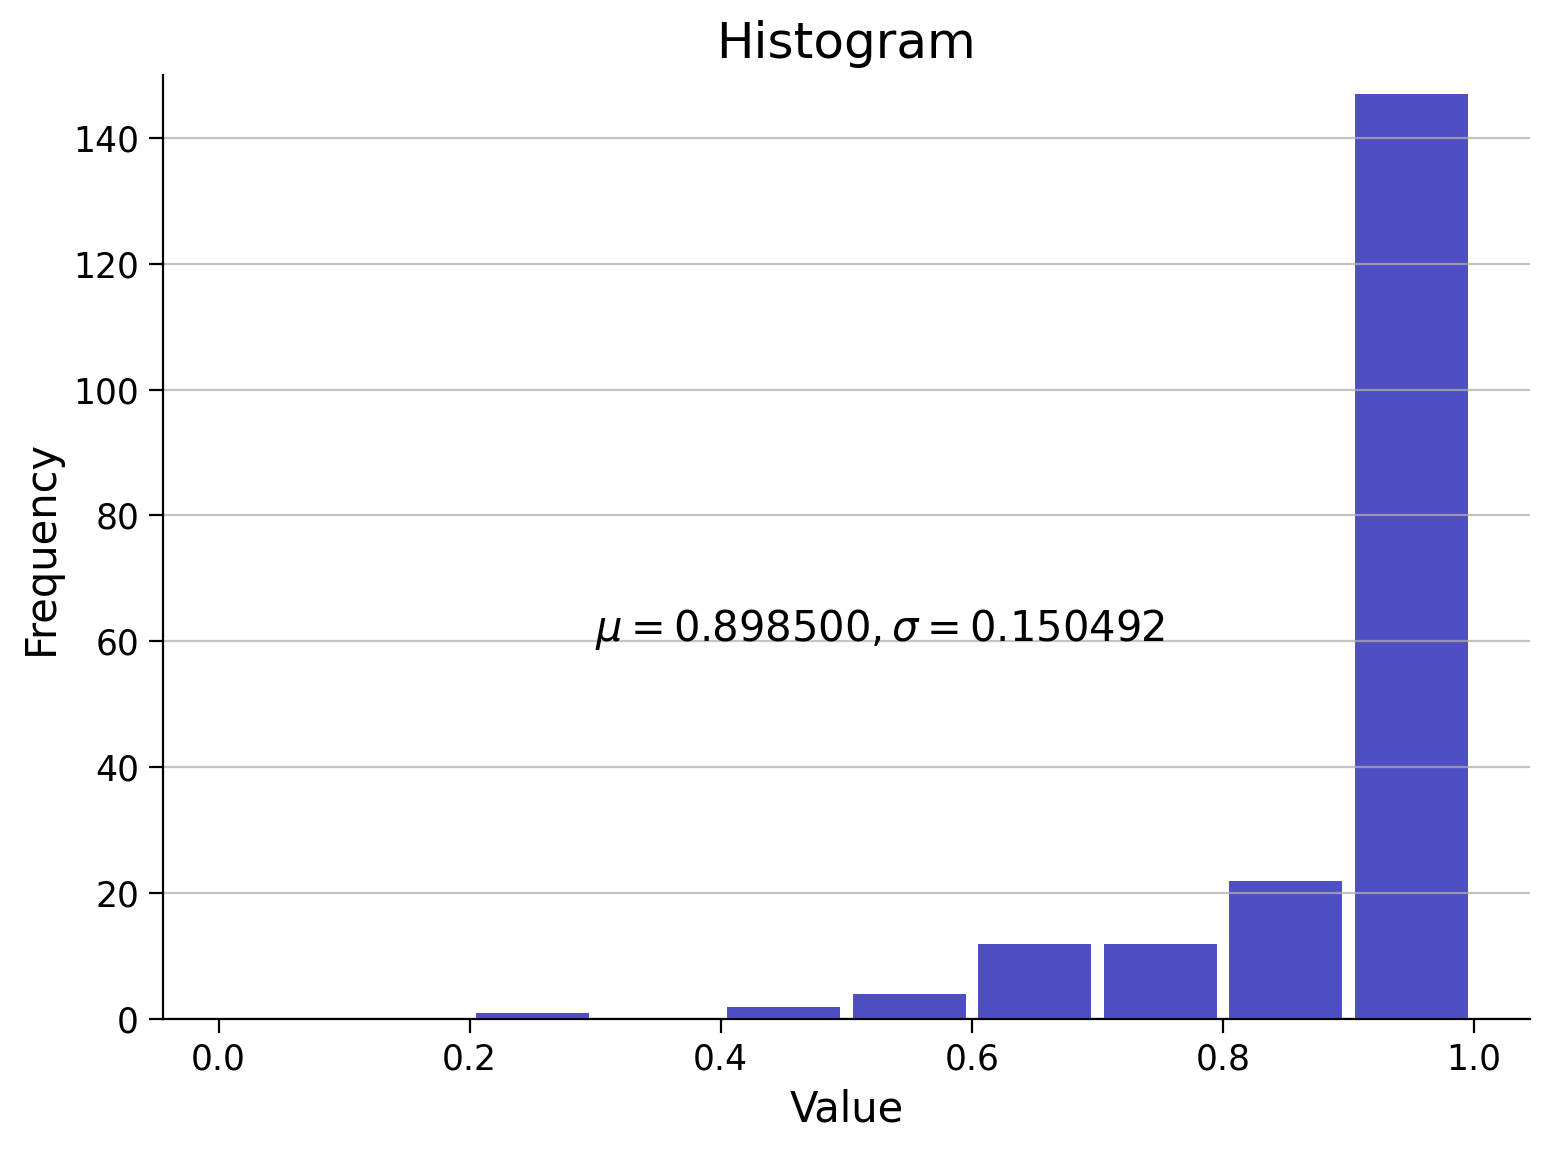

In [36]:
my_exp = 'WM'
my_cond  = [EXPERIMENTS[my_exp]['cond'][0]]
# my_cond  = EXPERIMENTS[my_exp]['cond'][5:8]
my_run = [0,1]

X,y = load_dataset(my_run,my_cond,my_exp)
# X,y = load_deep_dataset(my_run,my_cond,my_exp)

y_std  = np.std(y)
y_mean = np.mean(y)
alpha = 0

X2 = []
y2 = []

for i in range(y.shape[0]):
  if y[i] > y_mean + y_std*alpha or y[i] < y_mean - y_std*alpha:
    X2.append(X[i])
    y2.append(y[i])

X = np.array(X2)
y = np.array(y2)

print(X.shape)
print(y.shape)

# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=y, bins=np.array(range(0,11,1))/10, color='#0504aa',
                            alpha=0.7, rwidth=0.9)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram')
plt.text(0.3, 60, r'$\mu=%f, \sigma=%f$'%(y_mean,y_std),)
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
threshold = y_mean
y_bin = (y>threshold).astype(int)
print('Well Done!')

# **Model Defination**

In this section we use some classical machine learning model to fit the data such as Logistic Regression, SVM, KNN, Decision Tree, Random Forest, Native Bayes.


## **Split Dataset**

In [37]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.33, random_state=0,stratify=y_bin)
X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size=0.33, random_state=42,stratify=y_bin)

## Resample Data

In [38]:
from imblearn.over_sampling import SVMSMOTE

# Create an instance of SVMSMOTE
svm_smote = SVMSMOTE()

# Fit and oversample the training data
X_train_resampled, y_train_resampled = svm_smote.fit_resample(X_train, y_train)


Finally, we define the models we want to evaluate

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

models = []
models.append(LogisticRegression(solver='liblinear'))
models.append(SVC())
models.append(KNeighborsClassifier())
models.append(DecisionTreeClassifier())
models.append(RandomForestClassifier())
models.append(GaussianNB())


## **Model Evaluation**





In [40]:
model_list = ['Logistic Regression','SVM','KNN','Decision Tree','Random Forest','Naive Bayes']

acc_list = []
auc_list = []
cm_list = []

for model in models:
  model.fit(X_train_resampled,y_train_resampled)
  y_pred = model.predict(X_test)
  acc_list.append(metrics.accuracy_score(y_test,y_pred))
  fpr,tpr,_thersholds = metrics.roc_curve(y_test,y_pred)
  auc_list.append(round(metrics.auc(fpr,tpr),2))
  cm_list.append(confusion_matrix(y_test,y_pred))

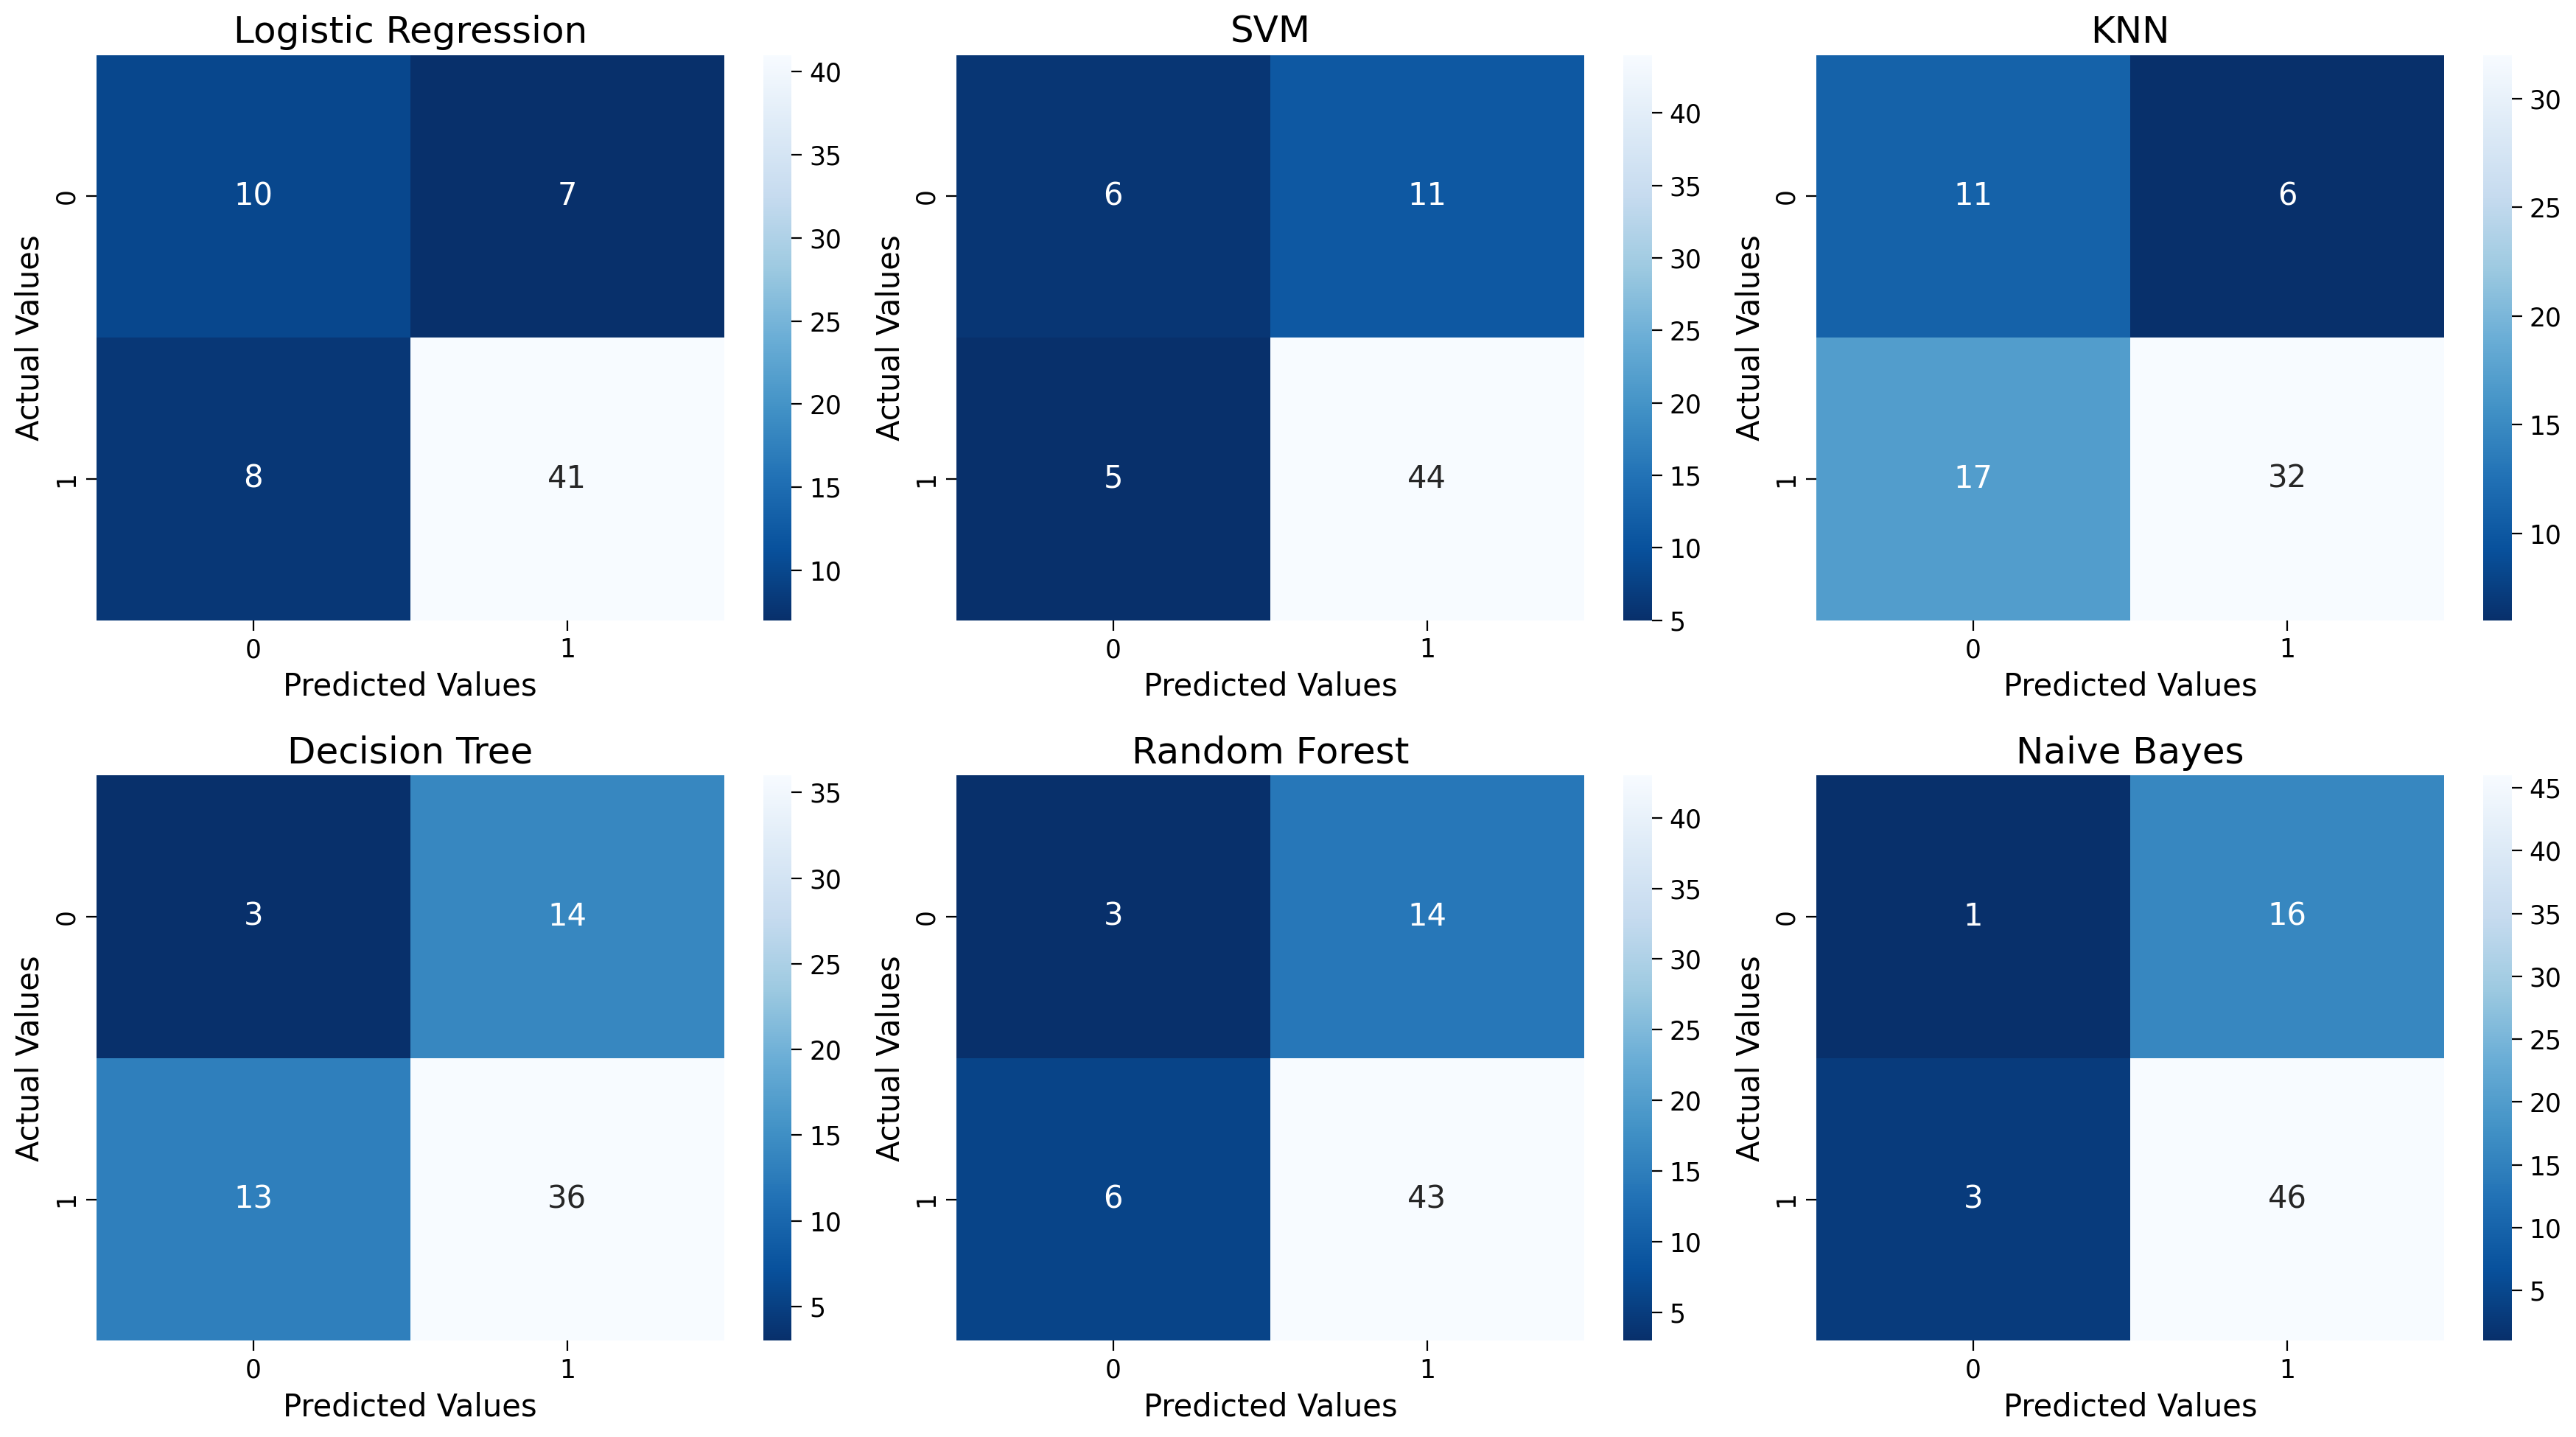

In [41]:
fig = plt.figure(figsize=(18,10))
for i in range(len(cm_list)):
  cm = cm_list[i]
  model = model_list[i]
  sub = fig.add_subplot(2,3,i+1).set_title(model)
  cm_plot = sns.heatmap(cm,annot=True,cmap='Blues_r')
  cm_plot.set_xlabel('Predicted Values')
  cm_plot.set_ylabel('Actual Values')


In [43]:
result = pd.DataFrame({'Model':model_list,'Accuracy':acc_list,'AUC':auc_list})
result

,Model,Accuracy,AUC
0,Logistic Regression,0.772727,0.71
1,SVM,0.757576,0.63
2,KNN,0.651515,0.65
3,Decision Tree,0.590909,0.46
4,Random Forest,0.696970,0.53
5,Naive Bayes,0.712121,0.50


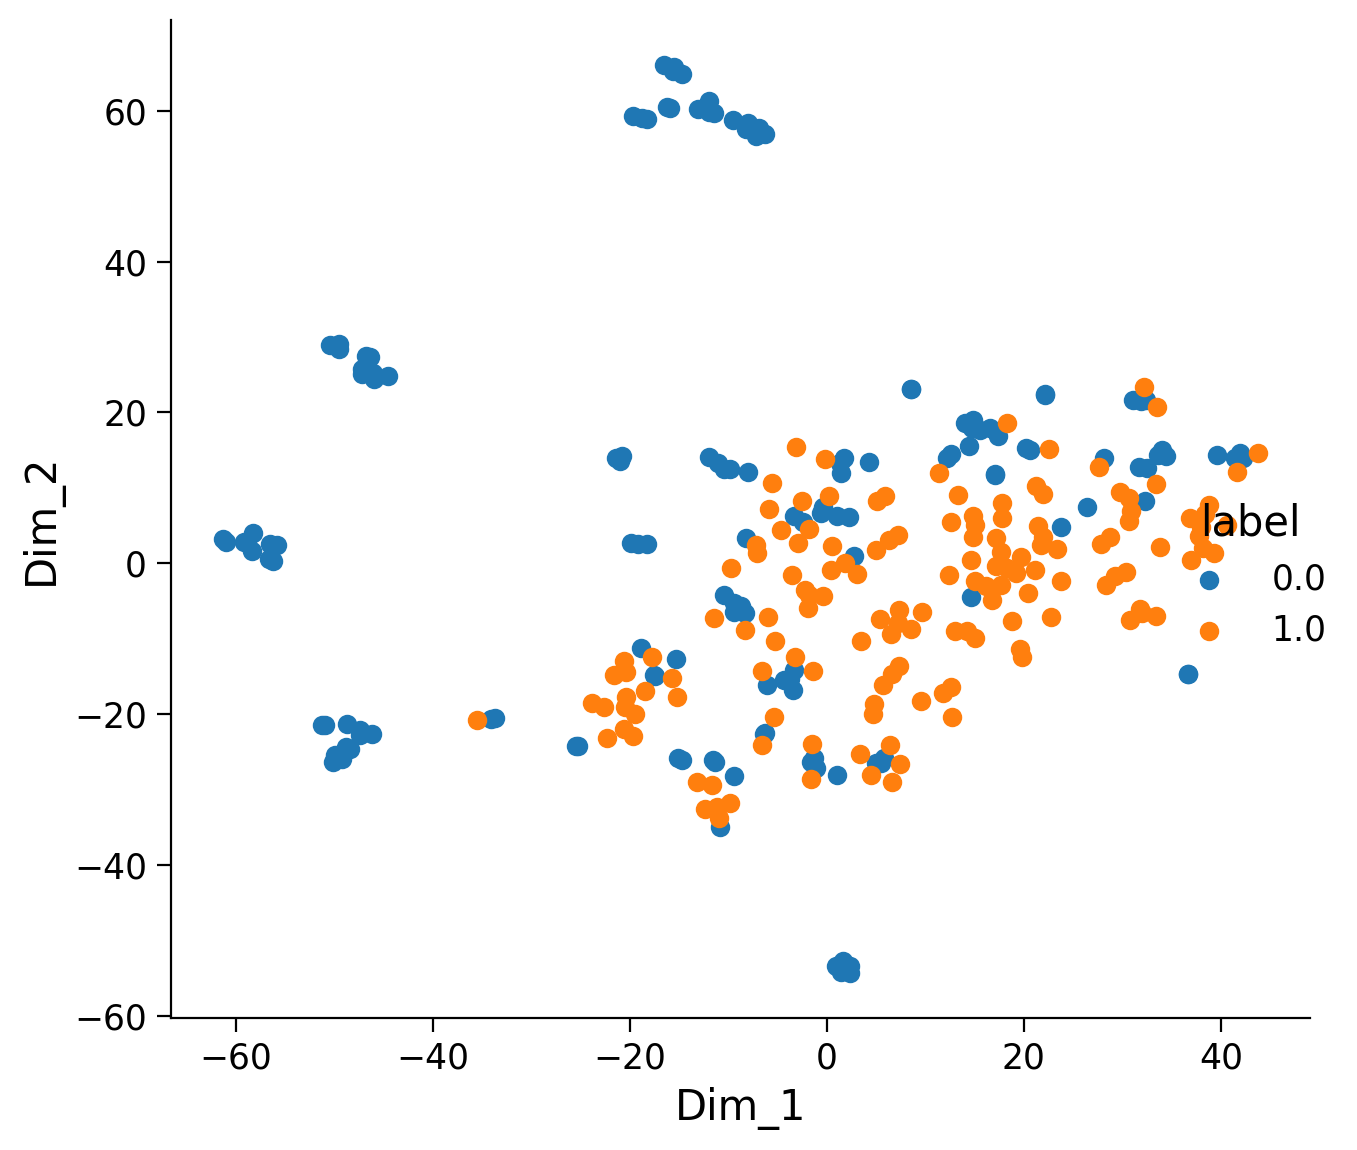

In [46]:
model = TSNE(n_components = 2, random_state = None,perplexity=5)
# configuring the parameters
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations
# for the optimization = 1000

# Create an instance of SVMSMOTE
svm_smote = SVMSMOTE()

# Fit and oversample the training data
X_resampled, y_resampled = svm_smote.fit_resample(X, y_bin)


tsne_data = model.fit_transform(X_resampled)

# creating a new data frame which
# help us in plotting the result data
tsne_data = np.vstack((tsne_data.T, y_resampled)).T
tsne_df = pd.DataFrame(data = tsne_data,
     columns =("Dim_1", "Dim_2", "label"))
# Plotting the result of tsne

sns.FacetGrid(tsne_df, hue ="label", height=6, aspect=1).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()

plt.show()

## **Logistic Regression**

Accuracy: 0.8043478260869565
AUC: 0.8


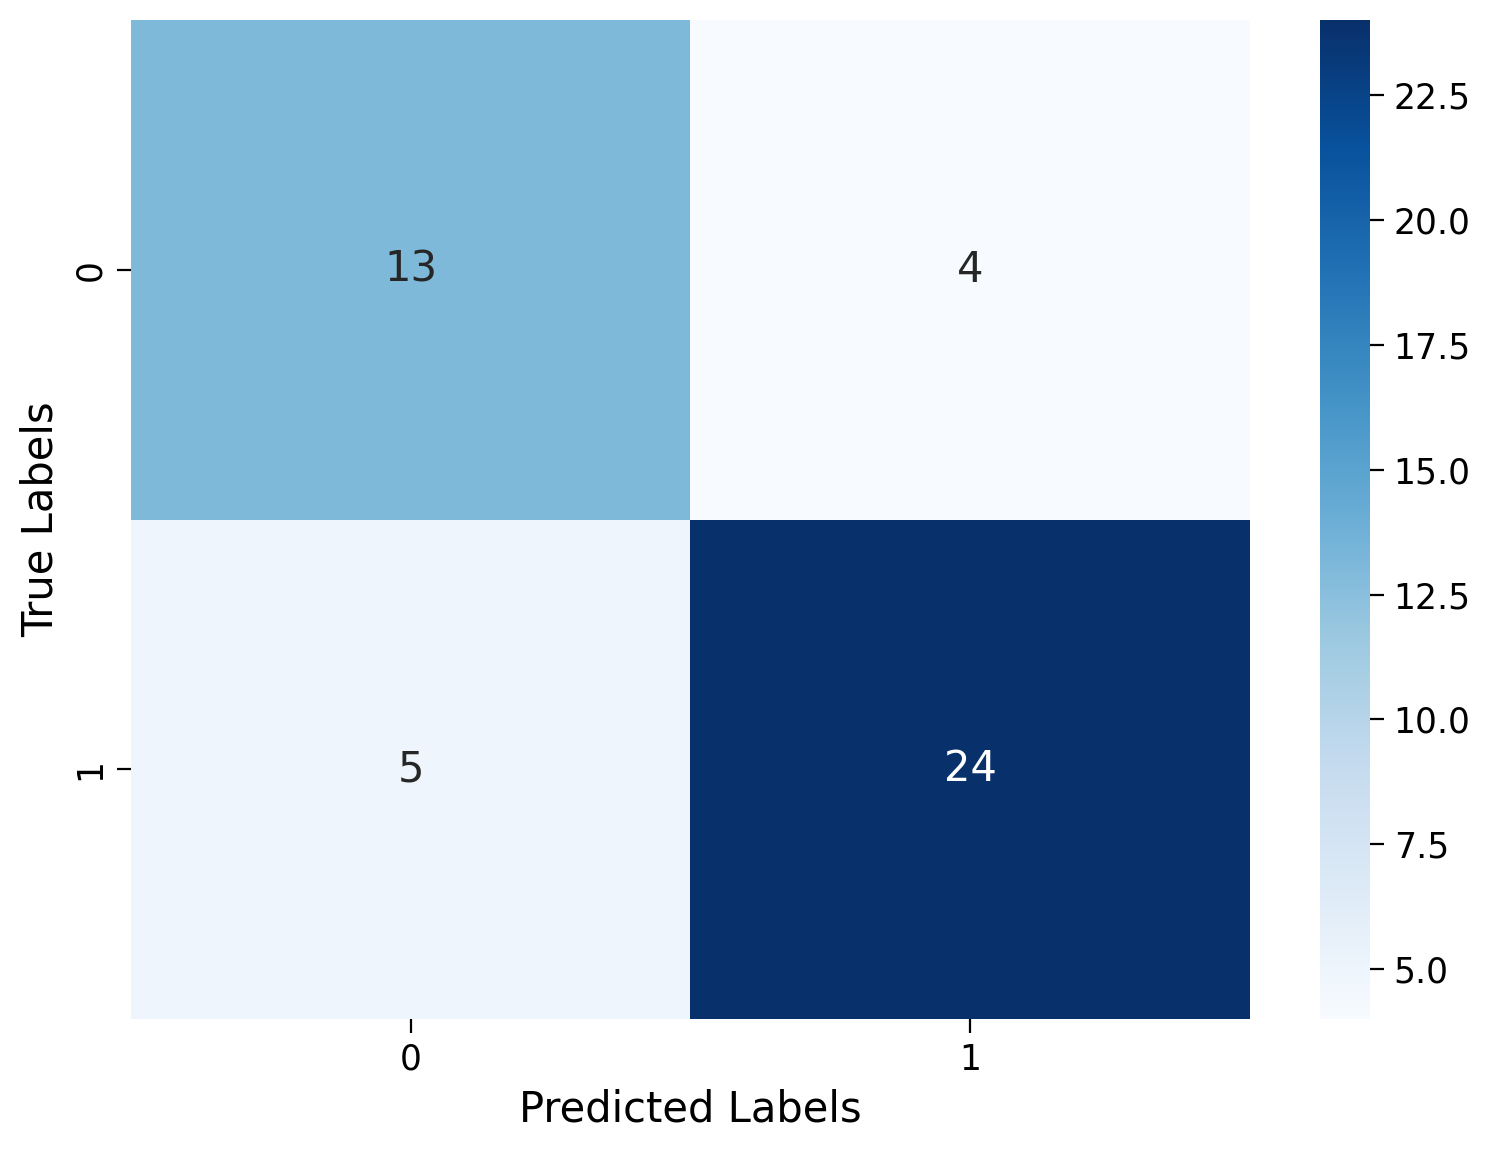

In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SVMSMOTE

seed = round(np.random.rand()*1000)
X_train_, X_test, y_train_, y_test = train_test_split(X, y_bin, test_size=0.2 , stratify=y_bin, random_state=seed)
X_train, X_val, y_train, y_val = train_test_split(X_train_, y_train_, test_size=0.25 , stratify=y_train_ ,random_state=seed)

# Create an instance of SVMSMOTE
svm_smote = SVMSMOTE(random_state=seed)
# Fit and oversample the training data
X_train, y_train = svm_smote.fit_resample(X_train, y_train)
# Create an instance of SVMSMOTE
svm_smote = SVMSMOTE(random_state=seed)
# Fit and oversample the training data
X_test, y_test = svm_smote.fit_resample(X_test, y_test)
# Create an instance of SVMSMOTE
svm_smote = SVMSMOTE(random_state=seed)
# Fit and oversample the training data
X_val, y_val = svm_smote.fit_resample(X_val, y_val)

C_values = [0.1,1,10]
solvers  = ['liblinear'] #,'newton_cholesky','sag','saga','lbfgs'

model = LogisticRegression(solver = 'liblinear',C=1)

model.fit(X_train, y_train)

y_pred = model.predict(X_val)

best_acc = 0
for C in C_values:
  for solver in solvers:

    model  = LogisticRegression(solver = solver,C=C)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    if acc > best_acc:
        best_acc = acc
        best_C = C
        best_solver = solver

X_train_val = np.concatenate((X_train, X_val), axis=0)
y_train_val = np.concatenate((y_train, y_val), axis=0)
model = LogisticRegression(solver = best_solver,C=best_C)
model.fit(X_train_val, y_train_val)

# Predict the labels on the test set
y_pred = model.predict(X_test)

# Evaluate the accuracy of the final model
acc = accuracy_score(y_test, y_pred)
print('Accuracy:', acc)

# Create a confusion matrix and classification report
cr = classification_report(y_test, y_pred)
fpr,tpr,_thersholds = metrics.roc_curve(y_test,y_pred)
auc=(round(metrics.auc(fpr,tpr),2))
print('AUC:',auc)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [50]:
from sklearn.model_selection import KFold, cross_val_score
k_folds = KFold(n_splits=5, shuffle=True, random_state=None)
Acc = cross_val_score(LogisticRegression(solver=best_solver,C=best_C), X, y_bin, cv=k_folds)  # k=8 cross validation
Auc = cross_val_score(LogisticRegression(solver=best_solver,C=best_C), X, y_bin, scoring = 'roc_auc', cv=k_folds)

print("Acc scores:", Acc)
print("Mean Acc score:", Acc.mean())
print("Standard deviation of AUC scores:", Acc.std())

print("AUC scores:", Auc)
print("Mean AUC score:", Auc.mean())
print("Standard deviation of AUC scores:", Auc.std())

Acc scores: [0.65  0.875 0.725 0.85  0.7  ]
Mean Acc score: 0.76
Standard deviation of AUC scores: 0.08746427842267951
AUC scores: [0.88714734 0.80859375 0.70666667 0.6577381  0.83928571]
Mean AUC score: 0.7798863123227349
Standard deviation of AUC scores: 0.08501604137463477


mean: 0.7561249999999999 std 0.05709079939009437
mean: 0.6791499999999999 std 0.07370059362040444

## SVM

Accuracy: 0.717391304347826
AUC: 0.64


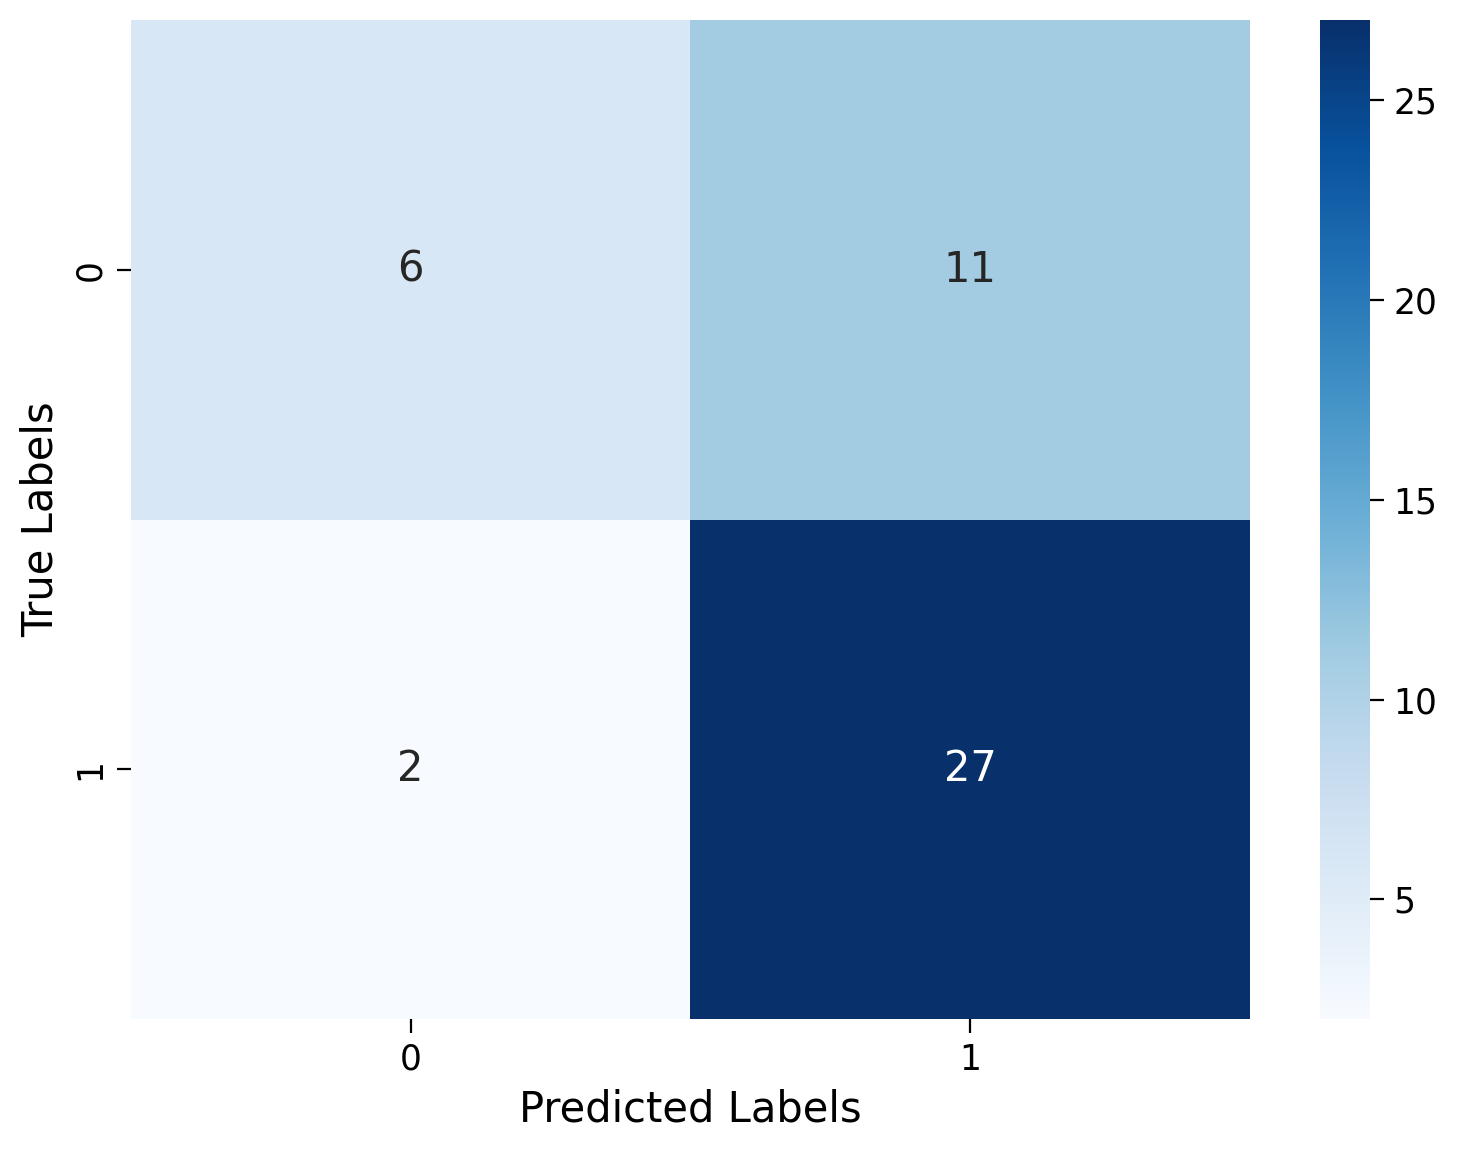

In [54]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SVMSMOTE

# initlize seed

seed = round(np.random.rand()*1000)

# Split the data into train, test, and validation sets

X_train_, X_test, y_train_, y_test = train_test_split(X, y_bin, test_size=0.2 , stratify=y_bin, random_state=seed)
X_train, X_val, y_train, y_val = train_test_split(X_train_, y_train_, test_size=0.25 , stratify=y_train_ ,random_state=seed)


# Create an instance of SVMSMOTE
svm_smote = SVMSMOTE(random_state=seed)
# Fit and oversample the training data
X_train, y_train = svm_smote.fit_resample(X_train, y_train)
# Create an instance of SVMSMOTE
svm_smote = SVMSMOTE(random_state=seed)
# Fit and oversample the training data
X_test, y_test = svm_smote.fit_resample(X_test, y_test)
# Create an instance of SVMSMOTE
svm_smote = SVMSMOTE(random_state=seed)
# Fit and oversample the training data
X_val, y_val = svm_smote.fit_resample(X_val, y_val)


# Train an SVM model on the training set
svm = SVC(kernel='linear', C=1, gamma='auto')
svm.fit(X_train, y_train)

# Predict the labels on the validation set
y_pred = svm.predict(X_val)

# Tune the hyperparameters using the validation set
C_values = [0.1, 1, 10]
gamma_values = ['scale', 'auto']
kernels = ['linear','rbf','sigmoid','poly']
best_acc = 0
for C in C_values:
    for gamma in gamma_values:
      for kernel in kernels:
        # print(kernel)
        svm = SVC(kernel=kernel, C=C, gamma=gamma)
        svm.fit(X_train, y_train)
        # svm.fit(X_train_resampled, y_train_resampled)
        y_pred = svm.predict(X_val)
        acc = accuracy_score(y_val, y_pred)
        if acc > best_acc:
            best_acc = acc
            best_C = C
            best_gamma = gamma
            best_kernel =  kernel

# print(best_kernel)
# Train the final model on the combined training and validation sets
# X_train_val = np.concatenate((X_train_resampled, X_val), axis=0)
# y_train_val = np.concatenate((y_train_resampled, y_val), axis=0)
X_train_val = np.concatenate((X_train, X_val), axis=0)
y_train_val = np.concatenate((y_train, y_val), axis=0)
svm = SVC(kernel=best_kernel, C=best_C, gamma=best_gamma)
svm.fit(X_train_val, y_train_val)

# Predict the labels on the test set
y_pred = svm.predict(X_test)

# Evaluate the accuracy of the final model
acc = accuracy_score(y_test, y_pred)
print('Accuracy:', acc)

# Create a confusion matrix and classification report
cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)
fpr,tpr,_thersholds = metrics.roc_curve(y_test,y_pred)
auc=(round(metrics.auc(fpr,tpr),2))
print('AUC:',auc)

sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [56]:
from sklearn.model_selection import KFold, cross_val_score
k_folds = KFold(n_splits=5, shuffle=True, random_state=None)
Acc = cross_val_score(SVC(kernel=best_kernel, C=best_C, gamma=best_gamma), X, y_bin, cv=k_folds)  # k=8 cross validation
Auc = cross_val_score(SVC(kernel=best_kernel, C=best_C, gamma=best_gamma), X, y_bin, scoring = 'roc_auc', cv=k_folds)

print("Acc scores:", Acc)
print("Mean Acc score:", Acc.mean())
print("Standard deviation of AUC scores:", Acc.std())

print("AUC scores:", Auc)
print("Mean AUC score:", Auc.mean())
print("Standard deviation of AUC scores:", Auc.std())

Acc scores: [0.725 0.85  0.85  0.775 0.775]
Mean Acc score: 0.7949999999999999
Standard deviation of AUC scores: 0.04847679857416328
AUC scores: [0.64666667 0.64672365 0.65517241 0.73828125 0.80877743]
Mean AUC score: 0.6991242813301002
Standard deviation of AUC scores: 0.06478653501321553


# **CNNs**


In [ ]:
import torchvision.transforms as transforms

# Define the mean and standard deviation for normalization
mean = [0.485]
std = [0.229]

# Create a list of transformations
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL image to PyTorch tensor
    transforms.Normalize(mean, std)  # Normalize the tensor
])

# Apply the transformation to your images
normalized_image = transform(X[0])

In [ ]:
from sklearn import preprocessing
from torch import unsqueeze
import torch

# mean = np.mean(X)
# std = np.std(X)

# print(mean,std)

mean = np.mean(X)
std = np.std(X)

def normalize_image(image_tensor, mean, std):
    normalized_image = (image_tensor - mean) / std
    return normalized_image

n = X.shape[0]
X_normalized=[]


for i in range(n):
  X_normalized.append(normalize_image(X[i], mean, std))


print((X_normalized)[0].shape)
print(len(X_normalized))


In [ ]:
# 1 channel to 3 channels

X_train  = torch.Tensor(X_train)
X_test  = torch.Tensor(X_test)
xx = torch.unsqueeze((X_train)[0], 0)
yy = torch.cat((xx, xx ,xx), 0)
print((xx).shape)
print((yy).shape)
torch.unsqueeze(yy, 0).shape

In [ ]:

## train
empty_tensor = torch.empty(1,3,360,39)
print(empty_tensor.shape)
for i in range(len(X_train)):
  xx = torch.unsqueeze((X_train)[i], 0)
  yy = torch.cat((xx, xx ,xx), 0)
  yy = torch.unsqueeze(yy, 0)
  #XX.append(yy)
  empty_tensor = torch.cat((empty_tensor,yy),-4)
#XX = torch.tensor(XX)
#print((empty_tensor[1]).shape)
print(empty_tensor[0].shape)
empty_tensor[0] = False
empty_tensor.shape
print((empty_tensor[2]).shape)


In [ ]:

# test

empty_tensor1 = torch.empty(1,3,360,39)
print(empty_tensor1.shape)
for i in range(len(X_test)):
  xx = torch.unsqueeze((X_test)[i], 0)
  yy = torch.cat((xx, xx ,xx), 0)
  yy = torch.unsqueeze(yy, 0)
  #XX.append(yy)
  empty_tensor1 = torch.cat((empty_tensor1,yy),-4)
#XX = torch.tensor(XX)
#print((empty_tensor[1]).shape)
print(empty_tensor1[0].shape)
empty_tensor1[0] = False
print(empty_tensor1.shape)
print((empty_tensor1[10]).shape)

In [ ]:

xx = torch.unsqueeze((X_train)[0], 0)
yy = torch.cat((xx, xx ,xx), 0)
print((xx).shape)
#rgb_image = transform((xx))
print((yy).shape)

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models


# split data
#X_train_, X_test, y_train_, y_test = train_test_split(X_normalized, y_bin, test_size=0.2 , stratify=y_bin, random_state=seed)

#print(type(X_test))

# X_train  = torch.from_numpy(X_train)
# X_test  = torch.from_numpy(X_test)
# y_train  = torch.from_numpy(y_train)
# y_test  = torch.from_numpy(y_test)

# Load the pre-trained ResNet50 model
resnet = models.resnet50(pretrained=True)

# Freeze the weights of the pre-trained layers
for param in resnet.parameters():
    param.requires_grad = False



# Replace the last fully connected layer for binary classification
num_features = resnet.fc.in_features
resnet.fc = nn.Linear(num_features, 1)

# Define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(resnet.parameters(), lr=0.001)
#-------------------------------------------------------------------------------------------------------------
# Train the model with your data
train_data = empty_tensor[1:]  # Your training data
print(train_data.shape)
train_labels = y_train_  # Your training labels
print(train_labels.shape)
#print(train_labels[0])
#print(len(train_labels))

num_epochs = 10
#batch_size = 32
batch_size = 20

print(len(train_data))
for epoch in range(num_epochs):
    for i in range(0, len(train_data), batch_size):

        inputs = train_data[i:i+batch_size]
        labels = train_labels[i:i+batch_size]
        # inputs = torch.cat([train_data[t] for t in range(i,i+batch_size+1)])
        # labels = torch.cat([train_labels[i:i+batch_size]])
        optimizer.zero_grad()


        #print(inputs.shape)


        outputs = resnet(inputs)


        loss = criterion(outputs.squeeze().float() , torch.tensor(labels).float())
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

# Make predictions on new data
test_data = empty_tensor1[1:]  # Your test data

with torch.no_grad():
    resnet.eval()
    outputs = resnet(test_data)
    predictions = torch.sigmoid(outputs).squeeze().tolist()

# Print the predicted classes


predicted_classes = [1 if pred > 0.5 else 0 for pred in predictions]
print(predicted_classes)

<class 'list'>


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([1, 115, 360])
tensor(1)
115
torch.Size([1, 1, 115, 360])


RuntimeError: ignored

In [ ]:
 print(y_test)
 print(predictions)
 predicted_classes = [1 if pred > threshold else 0 for pred in predictions]
 print(predicted_classes)
 print((np.sum(y_test==predicted_classes))/len(y_test))

In [ ]:
print(outputs.squeeze().shape)
print(type(outputs))
ss = torch.tensor(labels)
print(labels.shape)
print(type(ss))
(ss - outputs.squeeze())
